# Multi-Layer Networks

In the previous unit, we have used one-layer dense neural network to classify handwritten digits. Now let's see if adding more layers will give us better performance in terms of accuracy.

As in the previous unit, we will use `pytorchcv` helper to load all functions that we have defined in the previous units.

In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchsummary import summary

from pytorchcv import load_mnist, train, plot_results
load_mnist(batch_size=128)

## Multi-Layer Perceptron

In a multi-layer network, we will add one or more **hidden layers**.

![](images/dense_multilayer.png)

This layer may contain any number of neurons, which will affect how powerful our neural network it, i.e. how many parameters will it have. The more parameters there are in the network - the more data we need to train it.

> The **more** is not always the **better**. A number of parameters of a neural network should be chosen depending on the dataset size, to prevent **overfitting**.

Our network layer structure will look like this:

![](images/multilayer_layers.png)

An important thing to note here is the non-linear activation function layer, called **ReLU**. It is important to introduce those non-linear activation functions, because they are one of the reasons neural networks achieve high expressive power. Indeed, it can be demonstrated mathematically that if a network consisted just of a series of linear layers, it would essentially be equivalent to one linear layer. Thus inserting non-linear functions in between layers is important!

That's how two most frequently used activation functions look like:

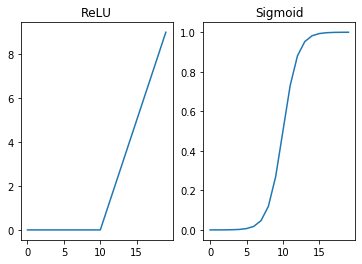

In [2]:
def plot_function(f,name=''):
    plt.plot([f(torch.tensor(x,dtype=torch.float32)).item() for x in range(-10,10)])
    plt.title(name)

plt.subplot(121)
plot_function(torch.relu,'ReLU')
plt.subplot(122)
plot_function(torch.sigmoid,'Sigmoid')


Our network can be defined in PyTorch in the following way, using `Sequential` syntax:

In [3]:
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,100),     # 784 inputs, 100 outputs
        nn.ReLU(),              # Activation Function
        nn.Linear(100,10),      # 100 inputs, 10 outputs
        nn.LogSoftmax())

summary(net,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              ReLU-3                  [-1, 100]               0
            Linear-4                   [-1, 10]           1,010
        LogSoftmax-5                   [-1, 10]               0
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


Here we use `torchsummary.summary()` function to display detailed layer-by-layer structure of a network, together with some other useful information. In particular, we can see the number of parameters of the network.

Let's train this multi-layered perceptron:

Epoch  0, Train acc=0.924, Val acc=0.954, Train loss=0.002, Val loss=0.001
Epoch  1, Train acc=0.963, Val acc=0.950, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.971, Val acc=0.954, Train loss=0.001, Val loss=0.001
Epoch  3, Train acc=0.975, Val acc=0.957, Train loss=0.001, Val loss=0.001
Epoch  4, Train acc=0.976, Val acc=0.970, Train loss=0.001, Val loss=0.001
Epoch  5, Train acc=0.980, Val acc=0.966, Train loss=0.001, Val loss=0.001
Epoch  6, Train acc=0.980, Val acc=0.971, Train loss=0.001, Val loss=0.001
Epoch  7, Train acc=0.984, Val acc=0.968, Train loss=0.000, Val loss=0.001
Epoch  8, Train acc=0.982, Val acc=0.961, Train loss=0.000, Val loss=0.002
Epoch  9, Train acc=0.984, Val acc=0.970, Train loss=0.000, Val loss=0.001


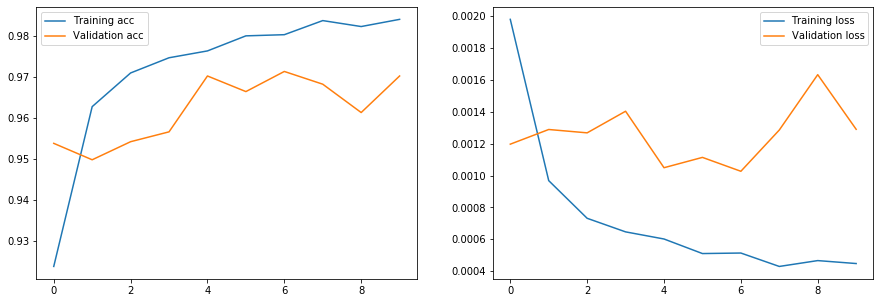

In [3]:
hist = train(net,train_loader,test_loader, epochs=5)
plot_results(hist)

Please note the following:
 * This network is more expressive then one layered perceptron we have trained in the previous unit. This it achieves much higher training accuracy, and given sufficiently large number of parameters - it can go almost to 100%
 * Validation accuracy at some point stops to increase - it means that the model reached it's ability to generalize, and further training will likely to result in overfitting.  

## Class-based Network Definition

Defining models using `Sequential` style as the list of layers seems very convenient, but it is somehow limited. At some point you may need to define more complex networks, which contain shared weights, or some non-linear connections between layers. 

In [4]:
from torch.nn.functional import relu,log_softmax

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(784,100)
        self.out = nn.Linear(100,10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden(x)
        x = relu(x)
        x = self.out(x)
        x = log_softmax(x)
        return x

net = MyNet()

summary(net,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
            Linear-3                   [-1, 10]           1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


You can see that the structure of a neural network (as presented by a call to `summary()`) is the same as with the `Sequential`-defined network, but the definition is more explicit. Our custom neural network is represented by a class inherited from [``torch.nn.Module``](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class.

Class definition consists of two parts:
* In the constructor (`__init__`) we define all layers that our network will have. Those layers are stored as internal variables of the class, and PyTorch will automatically know that parameters of those layers should be optimized when training. Internally, PyTorch uses `parameters()` method to look for all trainable parameters, and `nn.Module` will automatically collect all trainable parameters from all sub-modules. 
* We define the `forward` method that does the forward pass computation of our neural network. In our case, we start with a parameter tensor `x`, and explicitly pass it through all the layers and activation functions, starting from `flatten`, up to final linear layer `out`. When we apply our neural network to some input data `x` by writing `out = net(x)`, the `forward` method is called. 

In fact, `Sequential` networks are represented in a very similar manner, they just store a list of layers and apply them sequentially during the forward pass. Here we have a chance to represent this process more explicitly, which eventually gives us more flexibility. That is one of the reasons that using classes for neural network definition is a recommended way.

Now we will train our network and make sure we get almost the same results as before:

In [5]:
hist = train(net,train_loader,test_loader,epochs=5)
plot_results(hist)

Epoch  0, Train acc=0.924, Val acc=0.958, Train loss=0.002, Val loss=0.001
Epoch  1, Train acc=0.962, Val acc=0.963, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.970, Val acc=0.953, Train loss=0.001, Val loss=0.001
Epoch  3, Train acc=0.976, Val acc=0.968, Train loss=0.001, Val loss=0.001
Epoch  4, Train acc=0.979, Val acc=0.969, Train loss=0.001, Val loss=0.001


NameError: name 'hist' is not defined

## Takeaway

Multi-level networks can achieve higher accuracy than single-layer perceptron, however, they are not perfect for computer vision tasks. In images, there are some structural patterns that can help us classify an object regardless of it's position in the image, but perceptrons do not allow us to extract those patterns and look for them selectively. In the next unit we will focus on special type of neural networks that can be used effectively for computer vision tasks.